In [1]:
import os
import gc
import glob
import sys
import random
import string
import tqdm
import json
import time
import sqlite3
import warnings
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

from SmilesPE.pretokenizer import atomwise_tokenizer
from SmilesPE.pretokenizer import kmer_tokenizer
from SmilesPE.spe2vec import Corpus

from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from multiprocessing import Pool

from fastai import *
from fastai.text import *
#from utils import *
import torch

sys.path.append('../supp_scripts/')
import supp_utils as su

#torch.cuda.set_device(0) #change to 0 if you only has one GPU
# set gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()

Could not import custom script CNN


(device(type='cuda'), True)

In [2]:
input_file_test = "test_cids.txt" # Format cid in each line or cid - name in each line

Number_of_workers = 8
gpu_id = 0
if gpu_id != None:
    device = "cuda:" + str(gpu_id)
else:
    gpu_id = 0

torch.cuda.set_device(device)

spe_token_path = "pretraining_tokens.txt"

tokenization = "SPE"

pretraining_new_wt = "_model_clas"
batch_size = 64

parameter_filename = "parameters.json"
parameter_file = open(parameter_filename)
parameters = json.load(parameter_file)
parameter_file.close()
run_folder = parameters["run_folder"]
model_path = run_folder + "/models/"
function_file = "../data/preprocessed_data/protein_function_" + str(run_folder.split("_")[-1]) + ".yaml"
cluster_distance_file = "../data/cluster_results/cluster_distance_" + str(run_folder.split("_")[-1]) + ".csv"

In [3]:
# Ignore warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
# To remove rdkit warning
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [4]:
###OPTIONAL###
# To check whether the cid is present in the training file
#train_valid_filename = "cid_cluster_0.005.txt"

# Read cluster function file
with open(function_file, 'r') as stream:
    protein_function = yaml.safe_load(stream)
    
#with open("protein_function_0.005_large_sc_all_500.yaml", 'r') as stream:
#    protein_function_large = yaml.safe_load(stream)
    
cluster_distance = pd.read_csv(cluster_distance_file,header=None,names=["cluster1","cluster2","distance"])

In [5]:
# Reading input cid file and fetching from internet
input_cids = []
names = []
for entry in open(input_file_test,"r").readlines():
    cid = entry.split()[0]
    input_cids.append(cid)
    try:
        name = entry.split()[1]
        if len(entry.split()) > 2:
            name = ' '.join(entry.split()[1:])
        names.append(name)
    except:
        pass
cid_smiles = su.get_smiles_from_cid(input_cids,type_smiles="isomeric",get_from="SDF",folder_file_name="",save_output=False,remove_sdf=False)
test_df = pd.DataFrame([(cid_smiles[cid],cid) for cid in cid_smiles], columns=['Smiles','CID'])

In [6]:
# To check whether the cid is present in the training file (If needed uncomment the last line)
def check_presence_of_cid_in_train_valid_set(input_cid_list,train_file,valid_file=None):
    cid_train = [int(entry.split()[0]) for entry in open(train_valid_filename,"r").readlines() if len(entry) > 0]
    already_present = []
    for cid in input_cid_list:
        if cid in cid_train:
            already_present.append(cid)
    return (already_present,cid_train)

#already_present_train,cid_train = check_presence_of_cid_in_train_valid_set(list(map(int,(list(cid_smiles.keys())))),train_valid_filename)

def get_accuracy(yhat,y):
    softmax = torch.exp(yhat.float())
    prob = softmax.cpu().detach().numpy()
    predictions = np.argmax(prob, axis=1)
    y_truth = y.cpu().detach().numpy()
    accuracy_check = (y_truth==predictions)
    count = np.count_nonzero(accuracy_check)
    accuracy = (count/len(accuracy_check))
    return accuracy

In [7]:
# Initilizing tokenizer
if tokenization == "SPE":
    MolTokenizer = su.molpmofit.MolTokenizer_spe_sos_eos
    tok = Tokenizer(partial(MolTokenizer,token_path=spe_token_path), n_cpus=Number_of_workers, pre_rules=[], post_rules=[])
else:
    MolTokenizer = su.molpmofit.MolTokenizer_atomwise_sos_eos
    tok = Tokenizer(partial(MolTokenizer), n_cpus=Number_of_workers, pre_rules=[], post_rules=[])

tok = Tokenizer(partial(MolTokenizer,token_path=spe_token_path), n_cpus=Number_of_workers, pre_rules=[], post_rules=[])

In [8]:
with open(run_folder + "/valid_set.txt","r") as f:
    num_classes = list(set([entry.split()[1] for entry in f]))

In [9]:
# Reading vocab from the file
# The file is output of the training of final model
vocab = [vocab_token.strip() for vocab_token in open("text_class_vocab.txt","r").readlines()]
vocab_class = text.transform.Vocab(vocab)
test_data_clas = TextClasDataBunch.from_df("", test_df, test_df, bs=batch_size, tokenizer=tok, 
                              chunksize=50000, text_cols='Smiles',label_cols='CID', vocab=vocab_class, max_vocab=60000,
                                              include_bos=False,classes=[i for i in range(1,len(num_classes)+1)])

You can deactivate this warning by passing `no_check=True`.


In [11]:
# Loading the model
learner = text_classifier_learner(test_data_clas, AWD_LSTM, pretrained=False, drop_mult=0.2)
learner.model_dir = model_path
learner.load('_model_clas', purge=False);

In [12]:
# Prediction of clusters
cid_prediction = {}

for i,cid in enumerate(cid_smiles):
    smiles = cid_smiles[cid]
    results = learner.predict(smiles)
    prob = results[2].cpu().detach().numpy()
    predictions = results[1].cpu().detach().numpy().tolist()
    if len(names) > 0:
        cid_prediction[cid] = {"prediction":predictions,"name":names[i],"softmax_probability":max(prob)}
    else:
        cid_prediction[cid] = {"prediction":predictions,"softmax_probability":max(prob)}

In [13]:
# Get distance between clusters
predicted_clusters = []
for cid in cid_prediction:
    cluster = cid_prediction[cid]["prediction"]
    predicted_clusters.append(cluster)

cluster_distance_dicts = []
for clust1 in predicted_clusters:
    for clust2 in predicted_clusters:
        if clust1 != clust2:
            distance = cluster_distance[((cluster_distance["cluster1"] == clust1) | (cluster_distance["cluster2"] == clust1)) & \
                             ((cluster_distance["cluster1"] == clust2) | (cluster_distance["cluster2"] == clust2))]["distance"].tolist()[0]
        else:
            distance = 0
        entry1 = {"cluster1":clust1,"cluster2":clust2,"distance":distance}
        entry2 = {"cluster1":clust2,"cluster2":clust1,"distance":distance}
        if entry1 not in cluster_distance_dicts:
            cluster_distance_dicts.append(entry1)
        if entry2 not in cluster_distance_dicts:
            cluster_distance_dicts.append(entry2)

In [14]:
# Get distance between cids
cid_distance_dicts = []
for cid1 in cid_prediction:
    for cid2 in cid_prediction:
        clust1 = cid_prediction[cid1]["prediction"]
        clust2 = cid_prediction[cid2]["prediction"]
        for lists in cluster_distance_dicts:
            try:
                if lists['cluster1'] == clust1 and lists['cluster2'] == clust2:
                    distance = lists["distance"]
                    cid_distance = {"cid1":cid1,"cid2":cid2,"distance":distance}
                    cid_distance_dicts.append(cid_distance)
                    break
            except:
                pass

In [15]:
# Make distance matrix
cid_distance_matrix = []
for cid1 in input_cids:
    row_list = []
    for cid2 in input_cids:
        for lists in cid_distance_dicts:
            try:
                if lists['cid1'] == int(cid1) and lists['cid2'] == int(cid2):
                    distance = lists["distance"]
                    if distance == 0 and cid1 != cid2:
                        distance += 0.001
                    row_list.append(distance)
                    break
            except:
                pass
    cid_distance_matrix.append(row_list)
dm_array = np.array(cid_distance_matrix)

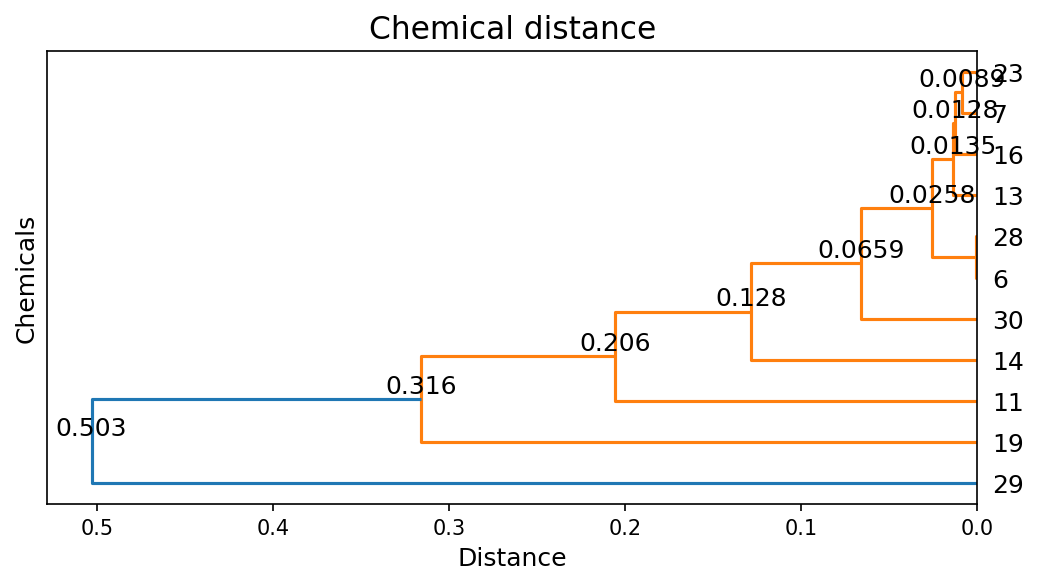

In [16]:
# Plot distance between the chemicals
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 150
def make_plot(distance_matrix,labels,figure_name="chemical_distance.png"):
    dists = squareform(distance_matrix)
    links = linkage(dists, "complete")
    ddata = dendrogram(links, labels=labels,leaf_font_size=12,orientation="left") 
    for i, d in zip(ddata['icoord'], ddata['dcoord']):
            y = 0.5 * sum(i[1:3])
            x = d[1]
            if x > 0.001:
                #plt.plot(x, y, 'ro')
                plt.annotate("%.3g" % x, (x, y), xytext=(0, +12),
                                 textcoords='offset points',
                                 va='top', ha='center',fontsize=12)

    plt.xlabel("Distance",fontsize=12)
    plt.ylabel("Chemicals",fontsize=12)
    plt.title("Chemical distance",fontsize=15)#, orientation='left'
    plt.savefig(figure_name)
    plt.show()
    
make_plot(dm_array,input_cids,"chemical_distance_cids.png")

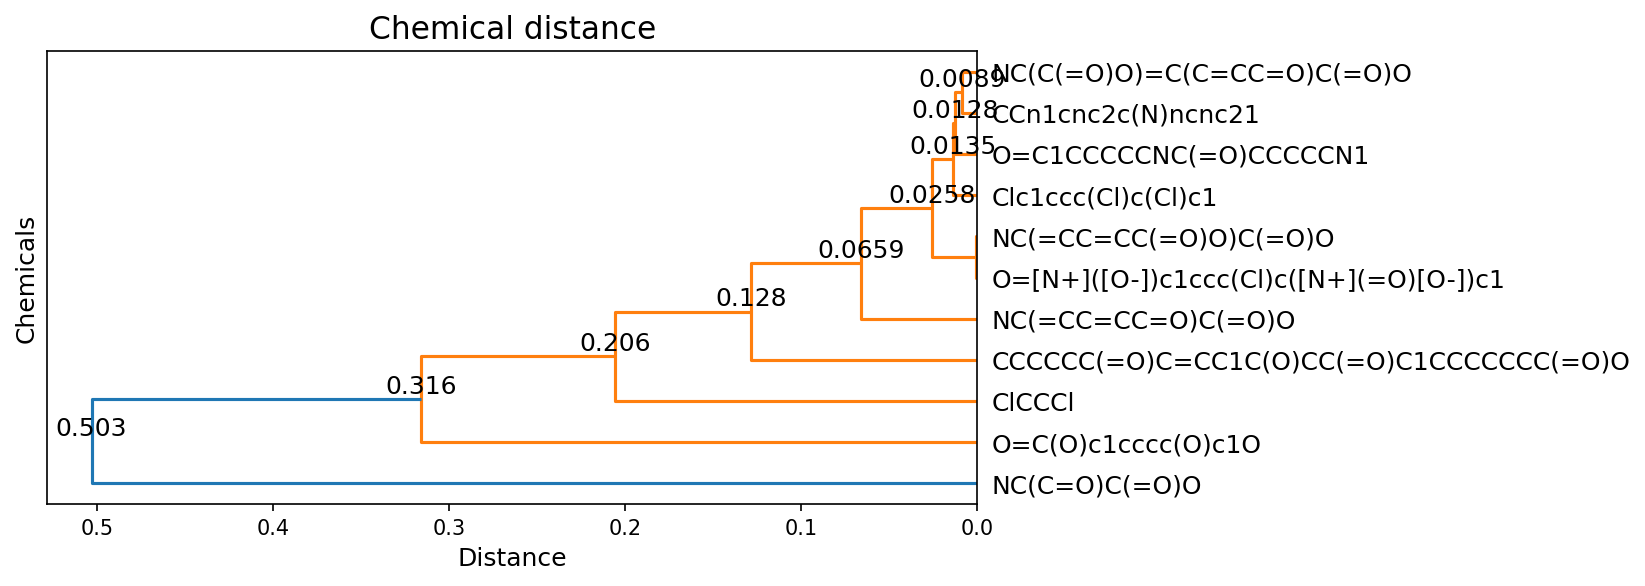

In [17]:
# If names are given, plot with names
if len(names) > 0:
    make_plot(dm_array,names,"chemical_distance_names.png")

In [18]:
# Club cluster prediction of same kind
cluster_cid = {}
for cid in cid_prediction:
    predicted_cluster = cid_prediction[cid]["prediction"]
    if predicted_cluster not in cluster_cid:
        cluster_cid[predicted_cluster] = []
    cluster_cid[predicted_cluster].append(cid)

In [19]:
# Get function of the cluster
def get_function_from_prediction(protein_function_file):
    for cluster in cluster_cid:
        cids = cluster_cid[cluster]
        print ("CIDs = " + str(cids)[1:-1])
        if len(names) > 0:
            chemical_names = []
            for cid in cids:
                index = input_cids.index(str(cid))
                chemical_names.append(names[index])
            print ("Chemical names = " + str(chemical_names)[1:-1])
        print ("Cluster predicted= " + str(cluster))
        print ("\nFunction\n")
        for i,entry in enumerate(protein_function_file[cluster]):
            print (str(i+1) + ".) " + str(entry)[1:-1] + "\n")
        print ("\n\n\n")

In [20]:
# PrWedictions
cid_prediction

{6: {'prediction': 194,
  'name': 'O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1',
  'softmax_probability': 0.36009696},
 7: {'prediction': 199,
  'name': 'CCn1cnc2c(N)ncnc21',
  'softmax_probability': 0.4975598},
 11: {'prediction': 28, 'name': 'ClCCCl', 'softmax_probability': 0.4446497},
 13: {'prediction': 190,
  'name': 'Clc1ccc(Cl)c(Cl)c1',
  'softmax_probability': 0.25568888},
 14: {'prediction': 96,
  'name': 'CCCCCC(=O)C=CC1C(O)CC(=O)C1CCCCCCC(=O)O',
  'softmax_probability': 0.46729496},
 16: {'prediction': 188,
  'name': 'O=C1CCCCCNC(=O)CCCCCN1',
  'softmax_probability': 0.0995667},
 19: {'prediction': 54,
  'name': 'O=C(O)c1cccc(O)c1O',
  'softmax_probability': 0.30916423},
 23: {'prediction': 192,
  'name': 'NC(C(=O)O)=C(C=CC=O)C(=O)O',
  'softmax_probability': 0.15435274},
 28: {'prediction': 194,
  'name': 'NC(=CC=CC(=O)O)C(=O)O',
  'softmax_probability': 0.18948774},
 29: {'prediction': 137,
  'name': 'NC(C=O)C(=O)O',
  'softmax_probability': 0.23575251},
 30: {'prediction': 59,

In [21]:
# Predictions and functions of the cluster with Qcutoff 
get_function_from_prediction(protein_function)

CIDs = 6, 28
Chemical names = 'O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1', 'NC(=CC=CC(=O)O)C(=O)O'
Cluster predicted= 194

Function

1.) 'count': 1516, 'frequency': 0.6412859560067682, 'function': 'Carbonic anhydrase 2; Essential for bone resorption and osteoclast differentiation (By similarity). Reversible hydration of carbon dioxide. Can hydrate cyanamide to urea. Involved in the regulation of fluid secretion into the anterior chamber of the eye. Contributes to intracellular pH regulation in the duodenal upper villous epithelium during proton-coupled peptide absorption. Stimulates the chloride-bicarbonate exchange activity of SLC26A6; Carbonic anhydrases', 'protein': 'ENSP00000285379'

2.) 'count': 659, 'frequency': 0.2787648054145516, 'function': 'Carbonic anhydrase 1; Reversible hydration of carbon dioxide. Can hydrates cyanamide to urea; Carbonic anhydrases', 'protein': 'ENSP00000256119'

3.) 'count': 52, 'frequency': 0.021996615905245348, 'function': 'Carbonic anhydrase 4; Reversibl